In [1]:
# Run the pip install command below if you don't already have the library
# !pip install git+https://github.com/JustAnotherArchivist/snscrape.git

import os
import math
import pandas as pd
import json
from pandas import json_normalize

import snscrape.modules.twitter as sntwitter
import itertools

import datetime
from random import randrange
import shutil

In [2]:
# Search terms: Content in the tweet
search_terms = [
    'coronavirus',
    'covid19',
    'pandemic',
    'quarantine',
]

# Testing additional Search Terms in Tweet Content Field. 
search_terms_two = [
    'vaxx',
    'unvaxxed'
    'antivaccine'
    'nomask',
    'maskoff',
    'masksdontwork',
]

# Creates a search parameter for the Twitter scraper
# since_date: inclusive
# until_date: exclusive
def search_builder(terms, area, since_date, until_date):    
    s = ''
    # Concatenate all search terms
    for i in range(len(terms) - 1):
        # NOTE: Inclusive OR statement
        s += '\"' + terms[i] + '\" OR '
    s += '\"' + terms[len(terms) - 1] + '\" '    
    
    # Within or the near the area
    s += 'near:\"' + area + '\" '
    # Since the first date
    s += 'since:' + since_date + ' '
    # Until the second date
    s += 'until:' + until_date
    
    return s

# Returns a DataFrame with at most tweet_limit tweets resulting from
# the search
def scrape(search_param, tweet_limit):
    return pd.DataFrame(itertools.islice(
        sntwitter.TwitterSearchScraper(search_param).get_items(), tweet_limit))

# Search for tweets in Los Angeles mentioning COVID terms
# from the beginning to the end of 2020.
los_angeles_search = search_builder(
    search_terms,
    "Los Angeles",
    '2020-01-01',
    '2020-12-31')

print(los_angeles_search)

"coronavirus" OR "covid19" OR "pandemic" OR "quarantine" near:"Los Angeles" since:2020-01-01 until:2020-12-31


In [3]:
# ********* STATE TWEET SCRAPING *********

def state_scraper(state, abbr, limit, since_date, until_date):

    total_tweets = 0

    print("Compiling tweets (max <=" + str(limit) + ") from " + state + " counties from " 
          + since_date + " to " + until_date)

    print("START: " + str(datetime.datetime.now()))

    counties = pd.read_csv("data/counties/" + abbr + "_counties.csv")

    for i in range(len(counties)):

        county = counties.iloc[i]['County']
        county.strip()
        
        county_search = search_builder(
            # CHANGE TO COUNTY SEARCH TERMS HERE!!!
            #search_terms,
            # search_terms -> search_terms_two
            search_terms_two,
            # CHANGE TO COUNTY SEARCH TERMS HERE!!!
            county + " County, " + abbr,
            since_date,
            until_date)

        county_tweets = scrape(county_search, limit)

        total_tweets = total_tweets + len(county_tweets)

        # Generates JSON with respective county tweet data
        county_json = county_tweets.to_json(county + ".json", lines=True, orient='records')

        source = os.getcwd() + "/" + county + ".json"
        destination = os.getcwd() + "/data/tweets/" + abbr + "_tweets/" + county + ".json"
        shutil.move(source, destination)

        print("(" + str(i + 1) + "/" + str(len(counties)) + ") " + county + " - " + str(len(county_tweets)) 
              + " tweets: " + str(datetime.datetime.now()))

    print("END: " + str(datetime.datetime.now()))
    print(str(total_tweets) + " tweets processed")

    
# California Tweet Scraper
def ca_scraper(tweet_limit, since_date, until_date):
    state_scraper("California", "CA", tweet_limit, since_date, until_date)

# Florida Tweet Scraper
def fl_scraper(tweet_limit, since_date, until_date):
    state_scraper("Florida", "FL", tweet_limit, since_date, until_date)

# New York Tweet Scraper
def ny_scraper(tweet_limit, since_date, until_date):
    state_scraper("New York", "NY", tweet_limit, since_date, until_date)
    
# Texas Tweet Scraper
def tx_scraper(tweet_limit, since_date, until_date):
    state_scraper("Texas", "TX", tweet_limit, since_date, until_date)

In [4]:
# Combining Each States Json Tweet files to a single pandas dataframe
import re

def file_paths(folder_path):
    # Stack overflow solution to finding only files in a directory using os.walk, previous attempt used listdir.
    # Article: https://stackoverflow.com/questions/52338706/isadirectoryerror-errno-21-is-a-directory-it-is-a-file
    path_list = [os.path.join(path, file) 
                      for path, directory, files in os.walk(folder_path) for file in files]
    return path_list

# Combine JSON files for efficiency then make a single dataframe.

# Take tweet from tweet folder.
# json_folder_path is the folder path containing the json files like ca_tweets.
def json_to_dataFrame(json_folder_path, json_folder_list, output_file):
    file_path_list = []
    for json_folder in json_folder_list:
        file_path_list.extend(file_paths('data/tweets/' + json_folder + json_folder_path))
 
    combined_json_file = 'data/tweets/results/' + output_file
# Stack overflow solution for combining json files. Combining json files was suggested as more efficient than
#  dataframes. Combines the json files into record oreint/format. 
# Article: https://stackoverflow.com/questions/23520542/issue-with-merging-multiple-json-files-in-python
    with open(combined_json_file, 'w') as combined_files:
        combined_files.write("{}".format("".join([open(file, "r").read() for file in file_path_list])))
# Dataframe using orient records because this was the specific formating used to collect the data. 
    dataframe = pd.read_json(combined_json_file, lines=True, orient='records')

    return dataframe

folder_list = ['2021-08-01_2021-08-08/', '2021-08-08_2021-08-15/', '2021-08-15_2021-08-22/', 
               '2021-08-22_2021-08-29/', '2021-08-29_2021-09-05/', '2021-09-05_2021-09-12/', 
               '2021-09-12_2021-09-19/', '2021-09-19_2021-09-26/', '2021-09-26_2021-10-03/']

### Dealing with Tweet Json Files

- Upon scrapping the Tweet data from Twitter we organized the data into folders referencing the weeks they were scrapped from.
<div>
    <img src='data/images/week_formated_folder.png' alt='Week Formated Folders', width='900'}/>
</div>
- We then combined these files using the json_to_dataFrame function to combine and give an initial visualiztion of the data.

``` python 
    ca_df = json_to_dataFrame('ca_tweets', folder_list, 'ca_results.json') 
```

- The 'ca_result.json' parameter in the above code snippet names the resulting combined files that is directed to a new results folder for easier access later.
    - This allows us to remove all of the week designated folders freeing up space and run a single ```pd.read_json()``` for the new combined files going forward.

### Dealing with Tweet Json Files : Texas Specific

- Specifically dealing with the Texas Tweet data we were unable to collect all of the tweets into a single json file because of the raw size of the data.
    - This brought us to the issue and realization that JSON files are larger than CSV files which we've noted as a crucial fix in the next iteration of our project experiments.
- In Conparison to the other States, Texas alone accounted for 83% of our Twitter data.
<div>
    <img src='data/images/texas_comparison.png' alt='Texas Comparison' width='700'/>
</div>

In [5]:
# Sentiment testing with HuggingFace
# Pip install the transfomers with Pytorch specifically. 
# !pip install transformers[torch]
from transformers import pipeline

def sentiment_analysis(dataframe):
    # Added print timeframe from State Scrapper
    print("START: " + str(datetime.datetime.now())[11:19])
    
    # Construct pipeline using sentiment-analysis to mesaure "sentiment" of tweet content
    classifier = pipeline("sentiment-analysis", model='distilbert-base-uncased-finetuned-sst-2-english')

    # Create empty list to collect sentiment values
    sentiment_list = []
    # For loop to take twitter content and analyze for sentiment values.
    for content in dataframe['content']:
        content_sentiment = classifier(content)
        # # Formated sentiment score
        # content_sentiment[0]['score'] = "{:.2f}%".format(content_sentiment[0]['score'] * 100)
        # # Append each new content sentiment to the list.
        # sentiment_list.append(content_sentiment[0])
        sentiment_list.append(content_sentiment[0]['label'])
        
    # Copy dataframe
    df_copy = dataframe.copy()
    
    # Added print timeframe from State Scrapper
    print("End: " + str(datetime.datetime.now())[11:19])
    # assign the new sentiment list values to the dataframe titled sentiment
    return df_copy.assign(sentiment = sentiment_list)

### Analyzing Sentiment of Twitter Content

- This portion of our project can argueably be labeled as the most time intensive as on average the Hugging Face sentiment analysis took around two hours to analyze 100K records.
    - We noticed that as the number of records increased the time required to process them slowly decreased.
    - For reference: 
        - ***California*** took 126 minutes (2 hours & 6 minutes) to process 101,403 records: **~805 records/minute**
        - ***Florida*** took 172 minutes (2 hours & 52 minutes) to process 139,048 records: **~808 records/minute**
        - ***New York*** took 170 minutes (2 hours & 50 minutes) to process 139,605 records: **~821 records/minute**
    - We can't say for certain that this trend is accurate since it doesn't take certain factors such as the average Tweet content length into account for each State. 

### Analyzing Sentiment of Twitter Content: continued

- We automated the analysis process by using our ```sentiment_analysis()``` function.
    - It takes in a Pandas dataframe and returned a new one with a sentiment column identifying NEGATIVE or POSITIVE Tweets.
    - To make life easier we also saved the resulting sentiment analyzed data into a CSV file(as we realized our mistake at this point in the project) for future use.
    ```python
        ca_sentiment_df = sentiment_analysis(ca_df)
        ca_sentiment_df.to_csv('data/tweets/sentiment/cs_sentiment.csv', index=False)
        ca_sentiment.head()
    ```
<div>
    <img src='data/images/sentiment_analyzed_data.png' alt='Sentiment Analyzed Data Ex.' width='1000'/>
</div>

### Analyzing Sentiment of Twitter Content: Texas again

- Again, because of the sheer amount of Tweets, the Texas data was treated slightly differently.
    - The individual weeks were analyzed and then combined into one ```'texas_sentiment.csv'``` at the end.

In [6]:
# ca_sentiment_df = pd.read_csv('data/tweets/sentiment/ca_sentiment.csv')
# ca_sentiment_df.head()

In [7]:
# fl_sentiment_df = pd.read_csv('data/tweets/sentiment/fl_sentiment.csv')
# fl_sentiment_df.head()

In [8]:
# ny_sentiment_df = pd.read_csv('data/tweets/sentiment/ny_sentiment.csv')
# ny_sentiment_df.head()

In [12]:
# Take tweet from tweet folder.
# json_folder_path is the folder path containing the json files like ca_tweets.
def combine_tx_sentiment_csv(csv_folder_path, output_file):
    file_path_list = []
    file_path_list.extend(file_paths(csv_folder_path))
    new_path_list = []
    i = 0
    for file in file_path_list:
        if 'tx' in file:
            new_path_list.append(file)
    new_path_list.sort()
    new_csv_path = 'data/tweets/sentiment/' + output_file
    with open(new_csv_path, 'w') as output:
        for i in range(len(new_path_list)):
            if i == 0:
                file = open(new_path_list[i]) 
            else:
                file = open(new_path_list[i])
                file.next() # skips first only works python 2
            for line in file:
                output.write(line)
        
combine_tx_sentiment_csv('data/tweets/sentiment', 'tx_sentiment.csv')

In [17]:
# tx_sentiment_df = pd.read_csv('data/tweets/sentiment/tx_sentiment.csv')
# tx_sentiment_df.loc[tx_sentiment_df['date'] == 'date']

In [3]:
# Fix date column to remove time from datetime for data visualization
def datetime_to_date(dataframe2):
    print("Start: " + str(datetime.datetime.now())[11:])
    df2_copy = dataframe2.copy()
    datetime_list = []
    for dt in dataframe2['date']:
         datetime_list.append(dt.date())
    new_date = pd.DataFrame(data={'date' : datetime_list})
    df2_copy['date'] = new_date['date']
    print("End: " + str(datetime.datetime.now())[11:])
    return df2_copy

In [37]:
ca_date_formatted_df = datetime_to_date(ca_sentiment_df)

Start: 23:40:49.620921
End: 23:40:49.897399


In [214]:
fl_date_formatted_df = datetime_to_date(fl_sentiment_df)

Start: 04:16:25.756427
End: 04:16:26.104998


In [11]:
ny_date_formatted_df = datetime_to_date(ny_sentiment_df)

Start: 11:18:23.510252


AttributeError: 'str' object has no attribute 'date'

In [ ]:
tx_date_formatted_df = datetime_to_date(tx_sentiment_df)

In [40]:
# Testing how many tweets were identified as 'positive' which may be an interesting insight to the accuracy of the 
#  sentiment analysis. Compare the content to ensure true positive sentiment and not sarcastic senitments.
ca_date_formatted_df.loc[ca_date_formatted_df['sentiment']=='NEGATIVE']

,date,content,renderedContent,user,hashtags,sentiment
0,2021-08-07,Los países que se apresuraron a relajar las me...,Los países que se apresuraron a relajar las me...,"{'username': 'RieraLizardo', 'id': 11552503421...",[COVID19],NEGATIVE
2,2021-08-07,Despite the effects caused by the COVID-19 pan...,Despite the effects caused by the COVID-19 pan...,"{'username': 'ObagaSam', 'id': 2545496694, 'di...","[Olympics, Springboks, BoksvLions, BBNaijaSeas...",NEGATIVE
3,2021-08-07,That second cat's expression is like\n\nIn a d...,That second cat's expression is like\n\nIn a d...,"{'username': 'ClickFlint', 'id': 2993602407, '...",None,NEGATIVE
4,2021-08-07,Protect the innocent children 🙏 \n\nA global p...,Protect the innocent children 🙏 \n\nA global p...,"{'username': 'DanicaA70317772', 'id': 12904817...",[CovidDeaths],NEGATIVE
6,2021-08-07,It makes sense because I live in a largely pan...,It makes sense because I live in a largely pan...,"{'username': 'KathleenCecilia', 'id': 18931812...",None,NEGATIVE
...,...,...,...,...,...,...
101396,2021-09-28,"@chick_in_kiev Maybe, but that’s no excuse for...","@chick_in_kiev Maybe, but that’s no excuse for...","{'username': 'davitydave', 'id': 6114542, 'dis...",None,NEGATIVE
101397,2021-09-26,[1/2] After a year during which uncertainty an...,[1/2] After a year during which uncertainty an...,"{'username': 'ldduval11', 'id': 119826872, 'di...",[WorkSmarter],NEGATIVE
101398,2021-10-02,Boy. This unprecedented run by the @SFGiants i...,Boy. This unprecedented run by the @SFGiants i...,"{'username': 'Mark_T_Rivera', 'id': 17452383, ...",None,NEGATIVE
101400,2021-09-30,@2muchsarcastic The pharmacist who gave me my ...,@2muchsarcastic The pharmacist who gave me my ...,"{'username': 'Musclegal', 'id': 18542394, 'dis...","[COVID19, BoosterShot, dodgedabullet]",NEGATIVE


In [170]:
import matplotlib.pyplot as plt
import datetime

list_of_dates = []
negative_x = []
x_tick_labels = []
# Visualizes data based on formatted dataframes for date and sentiment...
def sentiment_visualization(formatted_df, state):
    # Seperate the data based on sentiment.
    neg_sentiment_df = formatted_df.loc[formatted_df['sentiment']=='NEGATIVE']
    pos_sentiment_df = formatted_df.loc[formatted_df['sentiment']=='POSITIVE']
    # Collect unique date values
    neg_set_of_dates = set(neg_sentiment_df['date'])
    pos_set_of_dates = set(pos_sentiment_df['date'])
    set_of_dates = neg_set_of_dates.union(pos_set_of_dates)
    # added an additional date value at the end to assist in visualization issues during development.
#     set_of_dates.add(max(set_of_dates) + datetime.timedelta(days=1))
    set_of_dates.add(max(set_of_dates))
    # Sort dates
    list_of_dates = sorted(list(set_of_dates))
    # Create X and Y values lists for Negative sentiments.
    negative_x = []
    negative_y = []
    x_value = 0
    y_value = 0
    for i in range(len(list_of_dates)+1):
        if (i>0 and i%7 == 0) and i < len(list_of_dates):
            negative_x.append(int((x_value)/7))
            negative_y.append(y_value)
            x_value = x_value + 1
            y_value = len(neg_sentiment_df.loc[formatted_df['date'] == list_of_dates[i]])
        elif i == len(list_of_dates):
            negative_x.append(int((x_value)/7))
            negative_y.append(y_value)
        else:
            x_value = x_value + 1
            y_value = y_value + len(neg_sentiment_df.loc[formatted_df['date'] == list_of_dates[i]])
    # Create X and Y values lists for Positive sentiments.
    positive_x = []
    positive_y = []
    x_value = 0
    y_value = 0
    for i in range(len(list_of_dates)+1):
        if (i>0 and i%7 == 0) and i < len(list_of_dates):
            positive_x.append(int((x_value)/7) - 0.5)
            positive_y.append(y_value)
            x_value = x_value + 1
            y_value = len(pos_sentiment_df.loc[formatted_df['date'] == list_of_dates[i]])
        elif i == len(list_of_dates):
            positive_x.append(int((x_value+1)/7) - 0.5)
            positive_y.append(y_value)
        else:
            x_value = x_value + 1
            y_value = y_value + len(pos_sentiment_df.loc[formatted_df['date'] == list_of_dates[i]])
    # Reference: https://stackoverflow.com/questions/30228069/how-to-display-the-value-of-
    # the-bar-on-each-bar-with-pyplot-barh
    # User: Franck Dernoncourt
    # Code referenced for textual values in the bar graph
    
    # Create plot and assign figure size
    fig, axs = plt.subplots(figsize=(20,6))
    # Convert datetime dates to strings to assign to the 'x ticks' on the plot graph
    x_tick_labels = ['Week 1', 'Week 2', 'Week 3', 'Week 4', 'Week 5', 'Week 6', 'Week 7', 'Week 8', 'Week 9']

    # General bar width
    bar_widths = 0.25
    # Seperatly creating both bar plots and assign to the same subplot
    negative_bar = axs.bar(negative_x, negative_y, width=1/2, align='edge', color='red', 
                           label='Negative')
    positive_bar = axs.bar(positive_x, positive_y, width=1/2, align='edge', color='blue', 
                           label='Positive')
    # Label bar graph values
    barlabels(negative_bar, axs)
    barlabels(positive_bar, axs)
    # Label x tick values
    plt.xticks(negative_x, x_tick_labels)
    axs.set_title((state + ' Sentiment Visulaization'), fontsize=20)
    axs.set_xlabel('Dates', fontsize=16)
    axs.set_ylabel('Sentiment Counts', fontsize=16)
    plt.legend()
    plt.show()
    return list_of_dates, negative_x, x_tick_labels
# Function used to label the bar graph values 
def barlabels(bar_graph, axs):
    for bar in bar_graph:
        if bar.get_height() > 0:
            bar_height = bar.get_height()
            axs.text(bar.get_x() + bar.get_width()/2, bar_height, '%d' % int(bar_height),
                     ha='center', va='bottom')

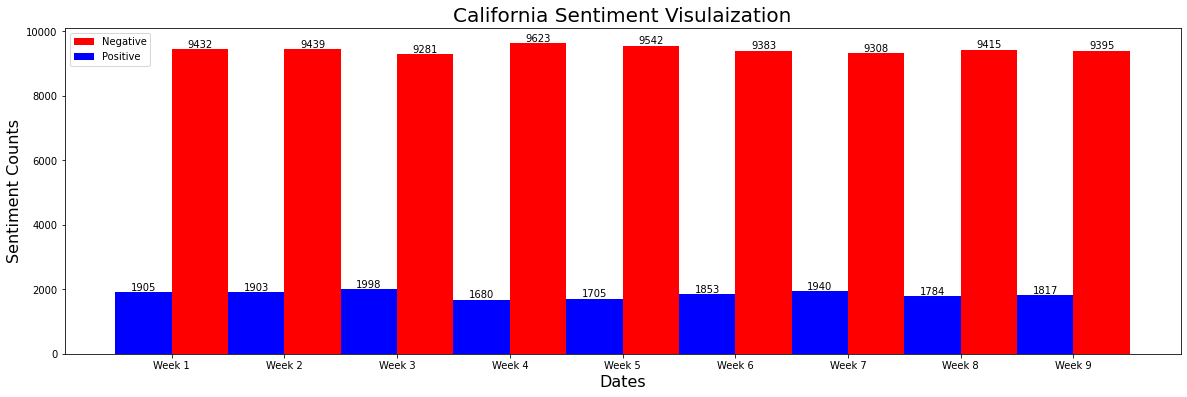

In [171]:
ca_date_list, ca_x_list, ca_x_labels = sentiment_visualization(ca_date_formatted_df, 'California')

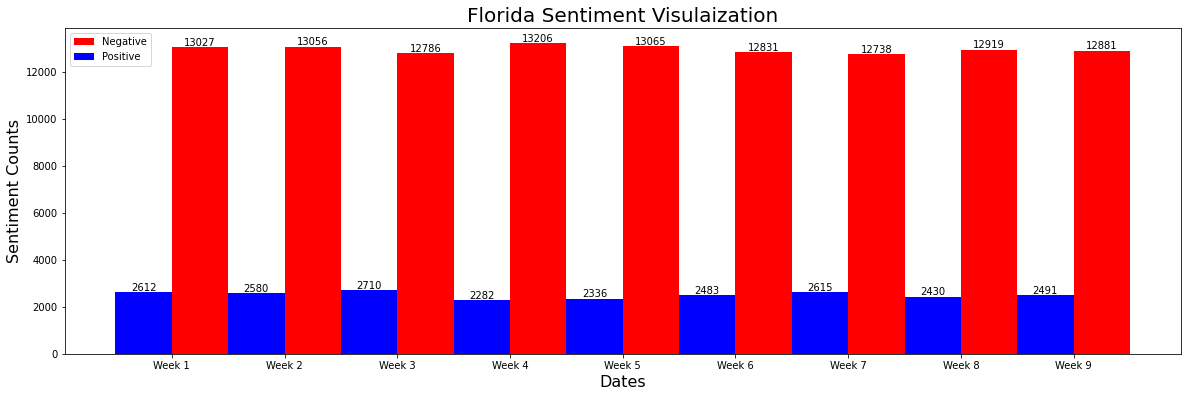

In [215]:
fl_date_list, fl_x_list, fl_x_labels = sentiment_visualization(fl_date_formatted_df, 'Florida')

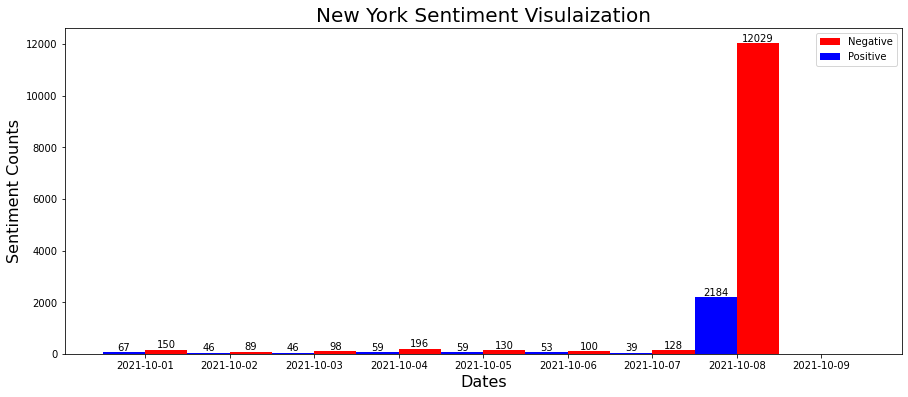

In [214]:
ny_date_list, ny_x_list, ny_x_labels = sentiment_visualization(ny_date_formatted_df, 'New York')

In [ ]:
tx_date_list, tx_x_list, tx_x_labels = sentiment_visualization(tx_date_formatted_df, 'Texas')

In [209]:
def str_to_date(covid_dataframe, column_name, date_format):
    c_df_copy = covid_dataframe.copy()
    new_date_list = []
    for dt in covid_dataframe[column_name]:
        new_date_list.append(datetime.datetime.strptime(dt, date_format))
    new_date_df = pd.DataFrame(data={'date' : new_date_list})
    c_df_copy[column_name] = new_date_df['date']
    c_df_copy = c_df_copy.rename(columns={column_name: "date"})
    return c_df_copy

### CHECK REASONING FOR CASE TOTALS AT WEEK 9

def cdc_state_case_visualization(cases_df, date_list, x_list, x_labels, state, axs_name):
    cases_list = []
    # Iterate through the list of days 
    week_count = 0
    index = 1
    for date in date_list:
    # Select case data based on the defined days
        if index%7 == 0 and index < len(date_list):
            cases_list.append(week_count)
            index = index + 1
            week_count = int(cases_df.loc[cases_df["date"] == str(date)]['New Cases'])
        elif index == len(date_list):
            cases_list.append(week_count)
        else:
            week_count = week_count + int(cases_df.loc[cases_df["date"] == str(date)]['New Cases'])
            index = index + 1

    # Testing graphical output of matplotlib... 
    # Line Graph version
    cases_line = axs_name.plot(x_list, cases_list, 'o-', alpha=0.4, color='black', label='Cases')

    for point in range(int(len(ca_date_list)/7)):
        axs_name.annotate('%d' % int(cases_list[point]), xy=((point+1), 1.01*cases_list[point]))

    fl_cases_axs.set_title(state + ' Cases', fontsize=20)
    fl_cases_axs.set_xlabel('Dates', fontsize=16)
    fl_cases_axs.set_ylabel('Case Counts', fontsize=16)
    plt.xticks(x_list, x_labels)
    plt.legend()
    plt.show()
    
def state_case_visualization(cases_df, counties_list, date_list, x_list, x_labels, county_label,
                             cases_label, state, axs_name):
    cases_list = []
    # Iterate through the list of days 
    week_count = 0
    index = 1
    for date in date_list:
    # Select case data based on the defined Counties and days
        if index%7 == 0 and index < len(date_list):
            index = index + 1
            cases_list.append(week_count)
            formatted_covid_df = cases_df[cases_df['date'].isin([str(date)])]
            county_covid_cases = formatted_covid_df[formatted_covid_df[county_label].isin(list(counties_list['County']))]
            week_count = int(sum(list(county_covid_cases[cases_label])))
        elif index == len(date_list):
            cases_list.append(week_count)
        else: 
            index = index + 1
            formatted_covid_df = cases_df[cases_df['date'].isin([str(date)])]
            county_covid_cases = formatted_covid_df[formatted_covid_df[county_label].isin(list(counties_list['County']))]
            week_count = week_count + int(sum(list(county_covid_cases[cases_label])))

    # Line Graph version
    cases_line = axs_name.plot(x_list, cases_list, 'o-', alpha=0.4, color='black', label='Cases')
    # Reference: https://stackoverflow.com/questions/22272081/label-python-data-points-on-plot
    # User: falsetru
    for point in range(int(len(date_list)/7)):
        axs_name.annotate('%d' % int(cases_list[point]), xy=((point+1), 1.01*cases_list[point]))
    # # Bar Graph equivalence.
    # cases_bar = axs_name.bar(x_list, cases_list, width= 0.5, alpha=0.4, color='black', label='Cases')
    # barlabels(cases_bar, axs_name)

    axs_name.set_title(state + ' Cases', fontsize=20)
    axs_name.set_xlabel('Dates', fontsize=16)
    axs_name.set_ylabel('Case Counts', fontsize=16)
    plt.xticks(x_list, x_labels)
    plt.legend()
    plt.show()

In [16]:
print(0%7)

0


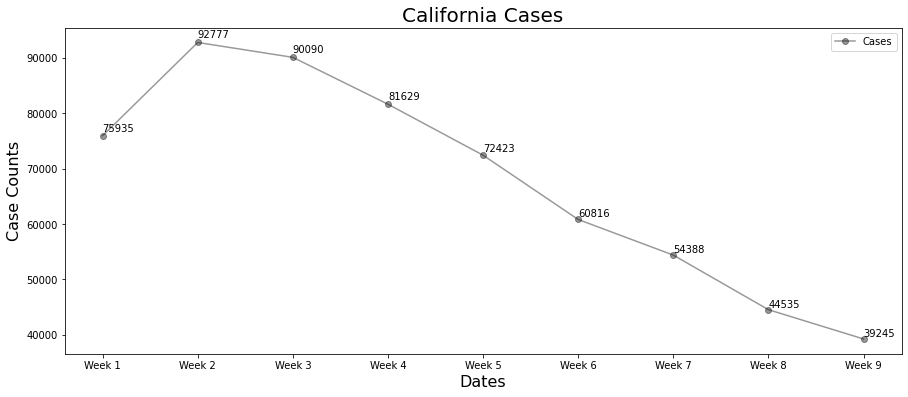

In [210]:
# California Case File from: https://data.chhs.ca.gov/dataset/covid-19-time-series-metrics-by-county-and-state
ca_covid_df = pd.read_csv("data/covid_data/ca_covid19_cases.csv")
# Drop majority of columns 
ca_covid_df = ca_covid_df.drop(['area_type', 'cumulative_cases', 'cumulative_deaths',
                                'cumulative_total_tests', 'cumulative_positive_tests', 
                                'cumulative_reported_cases', 'cumulative_reported_deaths'], axis=1)
# Testing graphical output of matplotlib... 
ca_cases_fig, ca_cases_axs = plt.subplots(figsize=(15,6))
# Read counties csv
ca_counties = pd.read_csv("data/counties/ca_counties.csv")

state_case_visualization(ca_covid_df, ca_counties, ca_date_list, ca_x_list, ca_x_labels, 
                         'area', 'cases', 'California', ca_cases_axs)

Start: 18:28:57.944104
End: 18:28:57.952362


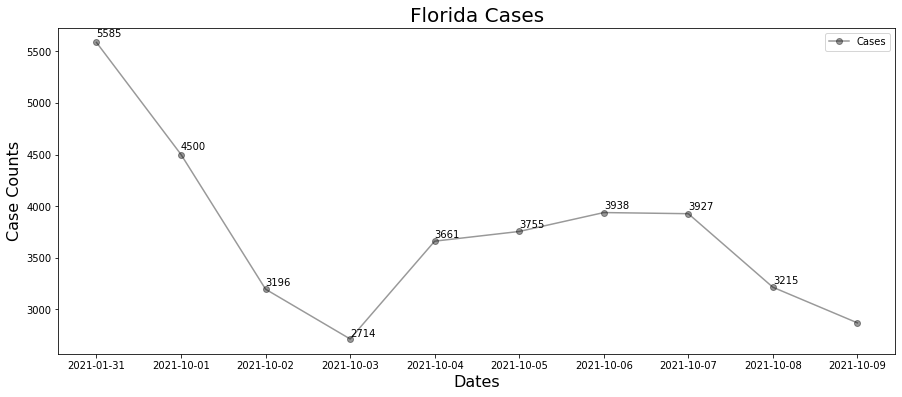

In [203]:
# FL Covid Case File from: https://covid.cdc.gov/covid-data-tracker/#trends_dailytr
#  endscases&territory-select=12&leftAxis=New_case&rightAxis=select
fl_covid_df = pd.read_csv("data/covid_data/fl_covid19_cases.csv", header=2)
fl_cases_df = str_to_date(fl_covid_df, 'Date', '%b %d %Y')

fl_cases_fig, fl_cases_axs = plt.subplots(figsize=(15,6))

cdc_state_case_visualization(fl_cases_df, fl_date_list, fl_x_list, fl_x_labels, 'Florida', fl_cases_axs)

Start: 19:04:18.965059
End: 19:04:19.252911


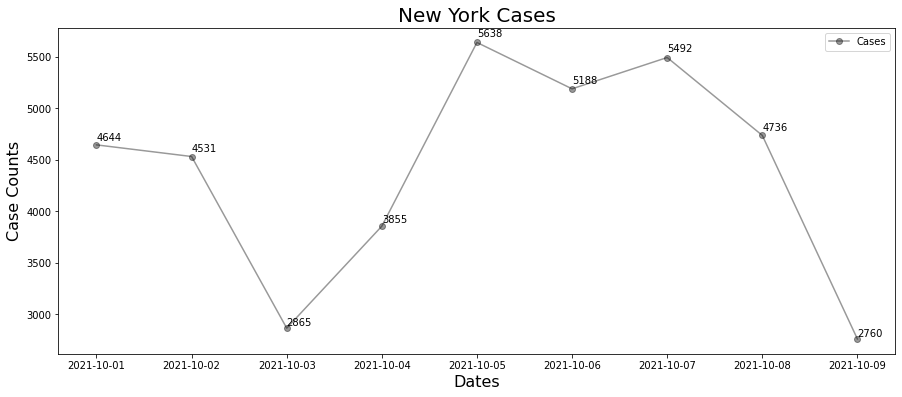

In [215]:
# NY Covid Case File from: https://health.data.ny.gov/Health/New-York-State-Statewide-COVID-19-Testing/xdss-u53e/data
ny_covid_df = pd.read_csv("data/covid_data/ny_covid19_cases.csv")

ny_cases_df = str_to_date(ny_covid_df, 'Test Date', '%m/%d/%Y')

# Testing graphical output of matplotlib... 
ny_cases_fig, ny_cases_axs = plt.subplots(figsize=(15,6))
# Read counties csv
ny_counties = pd.read_csv("data/counties/ny_counties.csv")

state_case_visualization(ny_cases_df, ny_counties, ny_date_list, ny_x_list, ny_x_labels, 
                         'County', 'New Positives', 'New York', ny_cases_axs)

Start: 16:53:13.519455
End: 16:53:13.527295


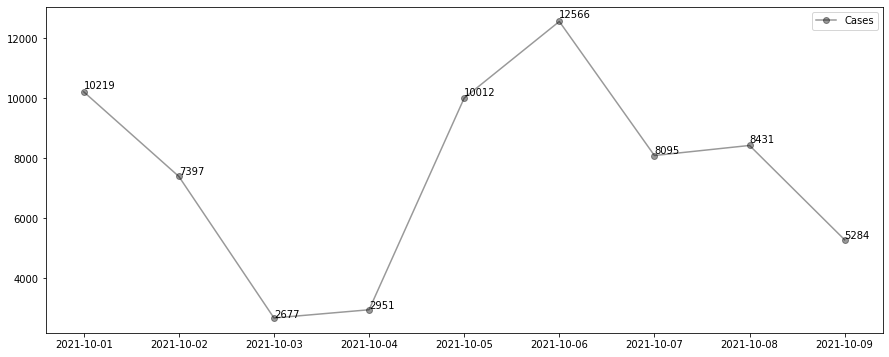

In [182]:
# Texas Covid Data from: https://covid.cdc.gov/covid-data-tracker/#trends_dailytr
#  endscases&territory-select=48&leftAxis=New_case&rightAxis=select
tx_covid_df = pd.read_csv("data/covid_data/tx_covid19_cases.csv", header=2)
tx_cases_df = str_to_date(tx_covid_df, 'Date', '%b %d %Y')
tx_cases_df

tx_cases_fig, tx_cases_axs = plt.subplots(figsize=(15,6))

cdc_state_case_visualization(tx_cases_df, tx_date_list, tx_x_list, tx_x_labels, 'Texas', tx_cases_axs)

In [72]:
ca_scraper(1000, "2021-10-01", "2021-10-09")

Compiling tweets (max <=1000) from California counties from 2021-10-01 to 2021-10-09
START: 2021-10-25 13:38:44.341007
(1/58) Alameda - 21 tweets: 2021-10-25 13:38:45.881042
(2/58) Alpine - 1000 tweets: 2021-10-25 13:39:09.837050
(3/58) Amador - 0 tweets: 2021-10-25 13:39:11.102162
(4/58) Butte - 1 tweets: 2021-10-25 13:39:12.396181
(5/58) Calaveras - 0 tweets: 2021-10-25 13:39:13.496967
(6/58) Colusa - 1000 tweets: 2021-10-25 13:39:36.111556
(7/58) Contra Costa - 19 tweets: 2021-10-25 13:39:37.566732
(8/58) Del Norte - 0 tweets: 2021-10-25 13:39:38.720221
(9/58) El Dorado - 0 tweets: 2021-10-25 13:39:39.831705
(10/58) Fresno - 7 tweets: 2021-10-25 13:39:41.169946
(11/58) Glenn - 1000 tweets: 2021-10-25 13:40:02.603418
(12/58) Humboldt - 3 tweets: 2021-10-25 13:40:03.850985
(13/58) Imperial - 0 tweets: 2021-10-25 13:40:05.220279
(14/58) Inyo - 1000 tweets: 2021-10-25 13:40:27.310050
(15/58) Kern - 0 tweets: 2021-10-25 13:40:28.652667
(16/58) Kings - 0 tweets: 2021-10-25 13:40:29.886437

In [73]:
fl_scraper(1000, "2021-10-01", "2021-10-09")

Compiling tweets (max <=1000) from Florida counties from 2021-10-01 to 2021-10-09
START: 2021-10-25 13:43:53.069049
(1/67) Alachua - 2 tweets: 2021-10-25 13:43:54.396436
(2/67) Baker - 0 tweets: 2021-10-25 13:43:55.864294
(3/67) Bay - 3 tweets: 2021-10-25 13:43:57.095982
(4/67) Bradford - 2 tweets: 2021-10-25 13:43:58.506500
(5/67) Brevard - 2 tweets: 2021-10-25 13:43:59.989494
(6/67) Broward - 27 tweets: 2021-10-25 13:44:02.865191
(7/67) Calhoun - 0 tweets: 2021-10-25 13:44:04.075572
(8/67) Charlotte - 1 tweets: 2021-10-25 13:44:06.441782
(9/67) Citrus - 1 tweets: 2021-10-25 13:44:07.913851
(10/67) Clay - 3 tweets: 2021-10-25 13:44:09.322266
(11/67) Collier - 4 tweets: 2021-10-25 13:44:11.197192
(12/67) Columbia - 0 tweets: 2021-10-25 13:44:12.497461
(13/67) De Soto - 1000 tweets: 2021-10-25 13:44:33.972711
(14/67) Dixie - 0 tweets: 2021-10-25 13:44:35.301368
(15/67) Duval - 1 tweets: 2021-10-25 13:44:36.607138
(16/67) Escambia - 0 tweets: 2021-10-25 13:44:38.432001
(17/67) Flagler - 

In [74]:
ny_scraper(1000, "2021-10-01", "2021-10-09")

Compiling tweets (max <=1000) from New York counties from 2021-10-01 to 2021-10-09
START: 2021-10-25 13:50:47.127010
(1/62) Albany - 2 tweets: 2021-10-25 13:50:48.532453
(2/62) Allegany - 0 tweets: 2021-10-25 13:50:50.087874
(3/62) Bronx - 415 tweets: 2021-10-25 13:51:09.882069
(4/62) Broome - 0 tweets: 2021-10-25 13:51:11.929999
(5/62) Cattaraugus - 1000 tweets: 2021-10-25 13:51:33.535964
(6/62) Cayuga - 1000 tweets: 2021-10-25 13:51:54.554562
(7/62) Chautauqua - 1 tweets: 2021-10-25 13:51:55.916112
(8/62) Chemung - 1000 tweets: 2021-10-25 13:52:17.777283
(9/62) Chenango - 1000 tweets: 2021-10-25 13:52:39.533305
(10/62) Clinton - 0 tweets: 2021-10-25 13:52:40.740557
(11/62) Columbia - 0 tweets: 2021-10-25 13:52:42.837750
(12/62) Cortland - 0 tweets: 2021-10-25 13:52:44.629477
(13/62) Delaware - 0 tweets: 2021-10-25 13:52:45.941733
(14/62) Dutchess - 6 tweets: 2021-10-25 13:52:47.189758
(15/62) Erie - 11 tweets: 2021-10-25 13:52:48.804933
(16/62) Essex - 1000 tweets: 2021-10-25 13:53:1

In [75]:
tx_scraper(1000, "2021-10-01", "2021-10-09")

Compiling tweets (max <=1000) from Texas counties from 2021-10-01 to 2021-10-09
START: 2021-10-25 13:58:00.572143
(1/254) Anderson - 1000 tweets: 2021-10-25 13:58:22.811629
(2/254) Andrews - 1000 tweets: 2021-10-25 13:58:45.415645
(3/254) Angelina - 1000 tweets: 2021-10-25 13:59:07.836704
(4/254) Aransas - 1000 tweets: 2021-10-25 13:59:29.363299
(5/254) Archer - 1000 tweets: 2021-10-25 13:59:50.296295
(6/254) Armstrong - 1000 tweets: 2021-10-25 14:00:12.225854
(7/254) Atascosa - 1000 tweets: 2021-10-25 14:00:45.014286
(8/254) Austin - 1000 tweets: 2021-10-25 14:01:06.418058
(9/254) Bailey - 1000 tweets: 2021-10-25 14:01:27.649272
(10/254) Bandera - 1000 tweets: 2021-10-25 14:01:48.893844
(11/254) Bastrop - 0 tweets: 2021-10-25 14:01:51.990935
(12/254) Baylor - 1000 tweets: 2021-10-25 14:02:13.239977
(13/254) Bee - 1000 tweets: 2021-10-25 14:02:34.524332
(14/254) Bell - 3 tweets: 2021-10-25 14:02:36.519826
(15/254) Bexar - 33 tweets: 2021-10-25 14:02:38.871012
(16/254) Blanco - 1000 twe

(140/254) Lamb - 1000 tweets: 2021-10-25 14:38:49.309231
(141/254) Lampasas - 1000 tweets: 2021-10-25 14:39:10.762286
(142/254) La Salle - 1000 tweets: 2021-10-25 14:39:32.756414
(143/254) Lavaca - 1000 tweets: 2021-10-25 14:39:53.370343
(144/254) Lee - 1000 tweets: 2021-10-25 14:40:15.248813
(145/254) Leon - 1000 tweets: 2021-10-25 14:40:37.113497
(146/254) Liberty - 0 tweets: 2021-10-25 14:40:40.910772
(147/254) Limestone - 0 tweets: 2021-10-25 14:40:42.102977
(148/254) Lipscomb - 1000 tweets: 2021-10-25 14:41:04.252068
(149/254) Live Oak - 1000 tweets: 2021-10-25 14:41:26.000914
(150/254) Llano - 1000 tweets: 2021-10-25 14:41:48.170697
(151/254) Loving - 0 tweets: 2021-10-25 14:41:49.349953
(152/254) Lubbock - 1000 tweets: 2021-10-25 14:42:10.793298
(153/254) Lynn - 1000 tweets: 2021-10-25 14:42:32.583014
(154/254) Madison - 1000 tweets: 2021-10-25 14:42:54.320934
(155/254) Marion - 1000 tweets: 2021-10-25 14:43:16.667794
(156/254) Martin - 0 tweets: 2021-10-25 14:43:18.060368
(157/

# References

California Counties: https://www.mapsofworld.com/usa/states/california/california-county-map.html

Florida Counties: https://www.mapsofworld.com/usa/states/florida/florida-county-map.html

New York Counties: https://www.mapsofworld.com/usa/states/new-york/new-york-county-map.html

Texas Counties: https://www.mapsofworld.com/usa/states/texas/texas-county-map.html